In [1]:
with open('Korean_movie_reviews_2016_small.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f ]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [2]:
len(texts)

29875

In [3]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

In [5]:
tokenizer = BertTokenizer.from_pretrained("beomi/kcbert-base")

In [6]:
model = TFBertForSequenceClassification.from_pretrained("beomi/kcbert-base", num_labels=2, from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, y_one_hot, test_size=0.2, random_state=0)

In [9]:
len(X_train)

23900

In [10]:
X_train_tokenized = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

In [11]:
optimizer = tf.keras.optimizers.Adam(2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = "./checkpoints/checkpoint_kcbert"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_best_only=True, save_weights_only=True)

In [13]:
history = model.fit(dict(X_train_tokenized), y_train, epochs=5, batch_size=128, 
                    validation_split=0.1, callbacks=[es, mc])

Epoch 1/5
169/169 [==============================] - 4056s 24s/step - loss: 0.3663 - accuracy: 0.8361 - val_loss: 0.2970 - val_accuracy: 0.8762
Epoch 2/5
169/169 [==============================] - 4417s 26s/step - loss: 0.2212 - accuracy: 0.9132 - val_loss: 0.2870 - val_accuracy: 0.8900
Epoch 3/5
169/169 [==============================] - 3947s 23s/step - loss: 0.1365 - accuracy: 0.9511 - val_loss: 0.3269 - val_accuracy: 0.8912
Epoch 4/5
169/169 [==============================] - 4581s 27s/step - loss: 0.0828 - accuracy: 0.9726 - val_loss: 0.3723 - val_accuracy: 0.8816
Epoch 5/5
169/169 [==============================] - 2730s 16s/step - loss: 0.0528 - accuracy: 0.9829 - val_loss: 0.4434 - val_accuracy: 0.8812
Epoch 5: early stopping


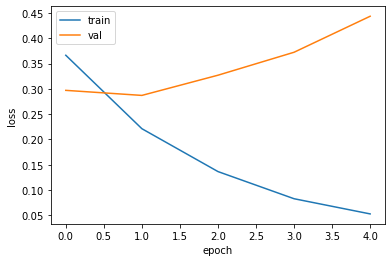

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

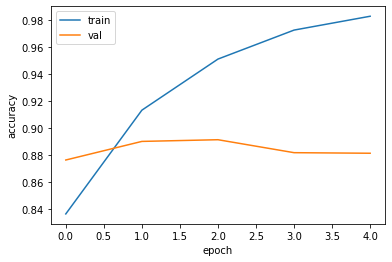

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [17]:
import numpy as np
model.load_weights(checkpoint_filepath)
y_preds = model.predict(dict(X_test_tokenized))
prediction_probs = tf.nn.softmax(y_preds.logits,axis=1).numpy()
y_predictions = np.argmax(prediction_probs, axis=1)
y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_predictions, y_test))

187/187 [==============================] - 281s 2s/step
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2749
           1       0.92      0.89      0.90      3226

    accuracy                           0.90      5975
   macro avg       0.90      0.90      0.90      5975
weighted avg       0.90      0.90      0.90      5975

